In [15]:
#Pytorch
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#Torchvision
import torchvision
from torchvision import datasets, models, transforms, utils
  
#Pytorch
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#Torchvision
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader

#Image Processing
import matplotlib.pyplot as plt
from skimage import io, transform, color
import PIL
from PIL import Image

#Others
import sklearn.metrics
from sklearn.metrics import *
import numpy as np
import pandas as pd
import cv2
import time
import os
import copy
from model_summary import *
import pretrainedmodels
import tqdm
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")



class dataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):

        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mask_dir = self.root_dir.replace('CBIS-DDSM_classification','masks')
        self.bmask_dir = self.root_dir.replace('CBIS-DDSM_classification','breast_mask')
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,self.data_frame.iloc[idx]['name'])
        image = Image.open(img_name)

        label = self.data_frame.iloc[idx]['category']

        mask_name = os.path.join(self.mask_dir,self.data_frame.iloc[idx]['name'].replace('.j','_mask.j'))
        mask = io.imread(mask_name)
        mask = np.array([mask,mask,mask]).transpose((1,2,0))
        mask = Image.fromarray(mask)
        
        bmask_name = os.path.join(self.bmask_dir,self.data_frame.iloc[idx]['name'].replace('.j','_bmask.j'))
        bmask = io.imread(bmask_name)
        bmask = np.array([bmask,bmask,bmask]).transpose((1,2,0))
        bmask = Image.fromarray(bmask)
        

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask) 
            bmask = self.transform(bmask)
    
        return {'image':image,'category':label,'mask':mask, 'bmask':bmask, 'name':img_name}
    

def get_dataloader(data_dir, train_csv_path, image_size, img_mean, img_std, batch_size=1):

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(image_size),#row to column ratio should be 1.69
            #transforms.RandomHorizontalFlip(0.5),
            #transforms.CenterCrop((image_size[1],image_size[1])),
            transforms.RandomVerticalFlip(0.5),
            transforms.RandomRotation(15),
            transforms.RandomAffine(translate=(0,0.2),degrees=15,shear=15),
            transforms.ToTensor(),
            #transforms.Normalize([0.223, 0.231, 0.243], [0.266, 0.270, 0.274])
            transforms.Normalize(img_mean,img_std)
        ]),
        'valid': transforms.Compose([
            transforms.Resize(image_size),
            #transforms.CenterCrop((image_size[1],image_size[1])),
            transforms.ToTensor(),
            #transforms.Normalize([0.223, 0.231, 0.243], [0.266, 0.270, 0.274])
            transforms.Normalize(img_mean,img_std)
        ]),
        'test': transforms.Compose([
            transforms.Resize(image_size),
            #transforms.CenterCrop((image_size[1],image_size[1])),
            transforms.ToTensor(),
            #transforms.Normalize([0.223, 0.231, 0.243], [0.266, 0.270, 0.274])
            transforms.Normalize(img_mean,img_std)
        ])
    }

    image_datasets = {}
    dataloaders = {}
    dataset_sizes = {}

    for x in ['train', 'valid', 'test']:
        image_datasets[x] = dataset(train_csv_path.replace('train',x),root_dir=data_dir,transform=data_transforms[x])
        dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,shuffle=True, num_workers=8)    
        dataset_sizes[x] = len(image_datasets[x])

    device = torch.device("cuda:0")

    return dataloaders,dataset_sizes,image_datasets,device

def build_selector():
#     class unetConv2(nn.Module):
#         def __init__(self, in_size, out_size, is_batchnorm):
#             super(unetConv2, self).__init__()

#             if is_batchnorm:
#                 self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, 3, 1, 1),
#                                            nn.BatchNorm2d(out_size),
#                                            nn.ReLU(),)
#                 self.conv2 = nn.Sequential(nn.Conv2d(out_size, out_size, 3, 1, 1),
#                                            nn.BatchNorm2d(out_size),
#                                            nn.ReLU(),)
#             else:
#                 self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, 3, 1, 1),
#                                            nn.ReLU(),)
#                 self.conv2 = nn.Sequential(nn.Conv2d(out_size, out_size, 3, 1, 1),
#                                            nn.ReLU(),)
#         def forward(self, inputs):
#             outputs = self.conv1(inputs)
#             outputs = self.conv2(outputs)
#             return outputs

#     class unetUp(nn.Module):
#         def __init__(self, in_size, out_size, is_deconv):
#             super(unetUp, self).__init__()
#             self.conv = unetConv2(in_size, out_size, False)
#             if is_deconv:
#                 self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
#             else:
#                 self.up = nn.UpsamplingBilinear2d(scale_factor=2)

#         def forward(self, inputs1, inputs2):
#             outputs2 = self.up(inputs2)
#             offset = outputs2.size()[2] - inputs1.size()[2]
#             padding = 2 * [offset // 2, offset // 2]
#             outputs1 = F.pad(inputs1, padding)
#             return self.conv(torch.cat([outputs1, outputs2], 1))

#     class unet(nn.Module):

#         def __init__(self, feature_scale=4, n_classes=1, is_deconv=True, in_channels=3, is_batchnorm=True):
#             super(unet, self).__init__()
#             self.is_deconv = is_deconv
#             self.in_channels = in_channels
#             self.is_batchnorm = is_batchnorm
#             self.feature_scale = feature_scale

#             filters = [32, 64, 128, 256, 512]
#             filters = [int(x / self.feature_scale) for x in filters]

#             #downsampling
#             self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
#             self.maxpool1 = nn.MaxPool2d(kernel_size=2)

#             self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
#             self.maxpool2 = nn.MaxPool2d(kernel_size=2)

#             self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
#             self.maxpool3 = nn.MaxPool2d(kernel_size=2)

#             self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
#             self.maxpool4 = nn.MaxPool2d(kernel_size=2)
                    
#             self.center = unetConv2(filters[3], filters[4], self.is_batchnorm)

#             # upsampling
#             self.up_concat4 = unetUp(filters[4], filters[3], self.is_deconv)
#             self.up_concat3 = unetUp(filters[3], filters[2], self.is_deconv)
#             self.up_concat2 = unetUp(filters[2], filters[1], self.is_deconv)
#             self.up_concat1 = unetUp(filters[1], filters[0], self.is_deconv)

#             # final conv (without any concat)
#             self.final = nn.Conv2d(filters[0], n_classes, 1)

#         def forward(self, inputs):
#             conv1 = self.conv1(inputs)
#             maxpool1 = self.maxpool1(conv1)

#             conv2 = self.conv2(maxpool1)
#             maxpool2 = self.maxpool2(conv2)

#             conv3 = self.conv3(maxpool2)
#             maxpool3 = self.maxpool3(conv3)

#             conv4 = self.conv4(maxpool3)
#             maxpool4 = self.maxpool4(conv4)

#             center = self.center(maxpool4)
#             up4 = self.up_concat4(conv4, center)
#             up3 = self.up_concat3(conv3, up4)
#             up2 = self.up_concat2(conv2, up3)
#             up1 = self.up_concat1(conv1, up2)

#             final = self.final(up1)

#             return final

    def same_padding(i, o, k, s, d=0):
    #     p = (k + (k-1)*(d-1) + (o - 1) * s - i) // 2 
        p = (k - 1) // 2
        return p

    class depthwise_block(nn.Module):
        def __init__(self, in_c, out_c, stride=1):
            super().__init__()
            self.bn1 = nn.BatchNorm2d(in_c)
            self.conv1 = nn.Conv2d(in_c, in_c, kernel_size=3,stride=stride, padding=same_padding(in_c,in_c,3,stride)
                ,groups=in_c, bias=False)
            self.conv2 = nn.Conv2d(in_c, out_c, kernel_size=1,stride=1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_c)

        def forward(self, inp):
            out = F.relu(self.bn1(self.conv1(inp)))
            out = F.relu(self.bn2(self.conv2(out)))
            return out

    #First channel wise deconv and then filtering
    class depthwise_deconv_block(nn.Module):
        def __init__(self, in_c, out_c, stride=1):
            super().__init__()
            self.bn1 = nn.BatchNorm2d(in_c)
            self.conv1 = nn.ConvTranspose2d(in_c, in_c, kernel_size=2,stride=2, padding=0
                ,groups=in_c, bias=False)
            self.conv2 = nn.Conv2d(in_c, out_c, kernel_size=1,stride=1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_c)


        def forward(self,input):
            output = F.relu(self.bn1(self.conv1(input)))
            output = F.relu(self.bn2(self.conv2(output)))
            return output
        
    class mobile_segnet(nn.Module):

        def __init__(self, feature_scale=2, n_out_channels=1, is_deconv=True, in_channels=3):
            super().__init__()
            self.is_deconv = is_deconv
            self.in_channels = in_channels
            self.feature_scale = feature_scale

            filters = [64, 128, 256, 512, 1024]
            filters = [int(x / self.feature_scale) for x in filters]

            downward = []
            for i in range(len(filters)):
                if i == 0:
                    downward.append(depthwise_block(self.in_channels, filters[i]))
                else:
                    downward.append(depthwise_block(filters[i-1], filters[i]))

                if i != (len(filters)-1):
                    downward.append(nn.MaxPool2d(kernel_size=2))
            self.downward = nn.Sequential(*downward)

            upward = []
            for i in range((len(filters))-1):
                upward.append(depthwise_deconv_block(filters[len(filters)-1-i], filters[len(filters)-2-i]))
            self.upward = nn.Sequential(*upward)

            self.final = nn.Conv2d(filters[0], n_out_channels, 1)

        def forward(self, inputs):

            x = self.downward(inputs)
            x = self.upward(x)
            x = self.final(x)

            return x

    model = mobile_segnet()
        
    #model = unet()
    #summary(model.cuda(),(3,320,192))

    return model

def build_predictor_discriminator():

    class pd(nn.Module):
        def __init__(self,base_model):
            super().__init__()
            self.base = base_model
            self.gap = nn.AdaptiveAvgPool2d((1,1))
            self.fc1 = nn.Linear(1536,256)
            self.do = nn.Dropout(0.5)
            self.fc2 = nn.Linear(256,2)

        def forward(self, x):
            x = self.base(x)
            x = self.gap(x)
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = self.do(x)
            x = self.fc2(x)
            return x #F.softmax(x)

    ir2 = pretrainedmodels.__dict__['inceptionresnetv2'](num_classes=1000, pretrained='imagenet')
    ir1 = nn.Sequential(*list(ir2.children())[:-2])
    for i in ir1.parameters():
        i.requires_grad = False
    for j in ir1[-1].parameters():
        j.requires_grad = True

    #model_ft = models.resnet18(pretrained=True)
    #r1 = nn.Sequential(*list(model_ft.children())[:-2])
    model = pd(ir1)
    
    #summary(model.cuda(),(3,320,192))
    
    return model

def denorm_img(img_ten,img_mean,img_std):

    bz,nc,h,w = img_ten.shape
    output = []
    img_num = img_ten.numpy()
    
    for i in range(bz):
        
        img = img_ten[i].numpy().squeeze()
        
        img[0,:,:] = img[0,:,:]*img_std[0]
        img[1,:,:] = img[1,:,:]*img_std[1]
        img[2,:,:] = img[2,:,:]*img_std[2]

        img[0,:,:] = img[0,:,:] + img_mean[0]
        img[1,:,:] = img[1,:,:] + img_mean[1]
        img[2,:,:] = img[2,:,:] + img_mean[2]
        
        img = img.mean(axis=0)
        img[img>=0.2*img.max()] = 1
        img[img<0.2*img.max()] = 0
        
        output.append(img)
    
    output = np.array(output)
    return output
    
def get_IoU(pred, targs, device):

    #pred = pred.numpy()
    max_pred = pred.max()
    #mean_pred = pred.mean()
    
    pred[pred>pred.mean() + pred.std()] = 1
    pred[pred<pred.mean() + pred.std()] = 0

    targs = torch.Tensor(targs).to(device)
    
    #targs = torch.Tensor((targs>0)).to(device)#.float()
    #pred = (pred>0)#.float()
    #return (pred*targs).sum() / ((pred+targs).sum() - (pred*targs).sum())
    
    return (pred*targs).sum()/targs.sum()

# def get_auc_roc(pred, targs):
    
#     bz,c = pred.shape
#     out = np.zeros(targs.shape)
#     for i in range(bz):
#         out[i] = pred[i][int(targs[i])]
#     return roc_auc_score(targs,out)

# def make_prob(a,device):
#     b = a.shape[0]
    
#     f1 = a.view(b,-1)
#     mi = torch.min(f1,-1)
    
#     t1 = torch.ones((b,1,1,1)).to(device)
#     t1[:,0,0,0] = mi[0]
    
#     d1 = a - t1
    
#     ma = torch.max(d1.view(b,-1),-1)
#     t2 = torch.ones((b,1,1,1)).to(device)
#     t2[:,0,0,0] = ma[0]
    
#     return d1/t2

class dc_invase():
    def __init__(self):
        
        #Initialization
        self.data_dir = '../Data/CBIS-DDSM_classification_orient/'
        self.train_csv = '../CSV/gain_train.csv'
        self.num_epochs = 100
        self.input_shape = (512,384)#(320,256)#(640,512) #(640,512)#(224,224)#(640,384) (640,512)
        self.batch_size = 1
        self.img_mean = [0.223, 0.231, 0.243]
        self.img_std = [0.266, 0.270, 0.274]
        self.alpha = 0.8
        self.beta = 0.1
        self.exp_name = 'dc_invase_ir2_mseg_bmask'
        
        #Define the three models
        self.selector = build_selector()
        self.predictor = build_predictor_discriminator()
        self.discriminator = build_predictor_discriminator()
        
        #Put them on the GPU
        self.selector = self.selector.cuda()
        self.predictor = self.predictor.cuda()
        self.discriminator = self.discriminator.cuda()
        
        #Get the dataloaders
        self.dataloaders,self.dataset_sizes,self.dataset,self.device = get_dataloader(self.data_dir,self.train_csv,\
                                                        self.input_shape,self.img_mean,self.img_std,self.batch_size)
        
        #Define the three optimizers one for each model
        self.optimizer_sel = optim.Adam(self.selector.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.optimizer_pred = optim.Adam(self.predictor.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.optimizer_dis = optim.Adam(self.discriminator.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        
#         self.lr_sched_sel = lr_scheduler.StepLR(self.optimizer_sel, step_size=10, gamma=0.1)
#         self.lr_sched_pred = lr_scheduler.StepLR(self.optimizer_pred, step_size=10, gamma=0.1)
#         self.lr_sched_dis = lr_scheduler.StepLR(self.optimizer_dis, step_size=10, gamma=0.1)

        self.l1_loss = nn.L1Loss()
        
        
        
    def train(self):
        
        since = time.time()
        best_epoch_pred_acc = 0.0
        best_epoch_iou = 0.0

        for epoch in range(self.num_epochs):
            print('Epoch {}/{}'.format(epoch, self.num_epochs - 1),flush=True)
            print('-' * 10,flush=True)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    
                    #Set the models to training mode
                    self.predictor.train() 
                    self.discriminator.train()
                    self.selector.train()
                
                else:
                    #Set the models to evaluation mode
                    self.predictor.eval()
                    self.discriminator.eval()
                    self.selector.eval()
                    
                #Keep a track of all the three loss
                running_sel_loss = 0.0
                running_pred_loss = 0.0
                running_dis_loss = 0.0
                running_spa = 0.0

                
                #Metrics : predictor auc and selector iou
                running_pred_auc = 0
                running_iou = 0
                running_pred_acc = 0
                running_dis_acc = 0

                #tqdm bar
                pbar = tqdm(total=self.dataset_sizes[phase])

                # Iterate over data.
                for sampled_batch in self.dataloaders[phase]:

                    inputs = sampled_batch['image']
                    labels = sampled_batch['category']
                    mask = denorm_img(sampled_batch['mask'],self.img_mean,self.img_std)
                    bmask = torch.Tensor(denorm_img(sampled_batch['bmask'],self.img_mean,self.img_std)).to(self.device)

                    #Input needs to be float and labels long
                    inputs = inputs.float().to(self.device)
                    labels = labels.long().to(self.device)

                    # zero the parameter gradients
                    self.optimizer_sel.zero_grad()
                    self.optimizer_pred.zero_grad()
                    self.optimizer_dis.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        
                        #import pdb;pdb.set_trace()
                        
                        #Generate selection probabilites using selector function. This will be the mask
                        sel_prob = F.sigmoid(self.selector(inputs))
                        sel_prob = sel_prob*bmask
                        #sel_prob = (sel_prob - sel_prob.min())/(sel_prob.max()-sel_prob.min())
                       
                        #Compute the Complementary selection probability
                        comp_sel_prob = 1 - sel_prob
                        
                        #Generate X_S the selection probability masked image
                        x_s = inputs*sel_prob
                        
                        #Generate X_S_bar the complementary selection probability masked image
                        x_s_bar = inputs*comp_sel_prob
                        
                        #Generate predictor output probabilities
                        pred_out = self.predictor(x_s)
                        pred_prob = F.softmax(pred_out)
                        _, pred_preds = torch.max(pred_out, 1)

                        
                        #Generate discriminator probabilities)
                        dis_out = self.discriminator(x_s_bar)
                        dis_prob = F.softmax(dis_out)
                        _, dis_preds = torch.max(dis_out, 1)

                        
                        #Predictor Cross entropy
                        pred_ce_loss = F.cross_entropy(pred_out,labels)
                        
                        #Discriminator Negative Cross entropy
                        dis_ce_loss = F.cross_entropy(dis_out,1-labels)
                        
                        #Selector function loss
                        #l2_norm = torch.norm(sel_prob.view((sel_prob.shape[0],-1)),2,-1)/torch.prod(torch.Tensor(self.input_shape).to(self.device))
                        #norm_loss = torch.mean(l2_norm)
                        
                        l1_loss = self.l1_loss(sel_prob,torch.zeros(sel_prob.shape,requires_grad=False).to(self.device))
                        
                        sel_loss = pred_ce_loss - self.alpha*F.cross_entropy(dis_out,labels) + self.beta*l1_loss
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            
                            #Update predictor using pred_ce_loss
                            #The gradients of pred_ce_loss should not update the params of disc or sel
                            pred_ce_loss.backward(retain_graph=True)
                            self.optimizer_sel.zero_grad()
                            self.optimizer_dis.zero_grad()
                            self.optimizer_pred.step()
                            
                            #The gradients of dis_ce_loss should not update the params of pred or sel
                            dis_ce_loss.backward(retain_graph=True)
                            self.optimizer_sel.zero_grad()
                            self.optimizer_pred.zero_grad()
                            self.optimizer_dis.step()
                            
                            #Update sel
                            sel_loss.backward()
                            self.optimizer_pred.zero_grad()
                            self.optimizer_dis.zero_grad()
                            self.optimizer_sel.step()
                                    
                    # statistics
                    running_sel_loss += sel_loss.item() * inputs.size(0)
                    running_pred_loss += pred_ce_loss.item() * inputs.size(0)
                    running_dis_loss += dis_ce_loss.item() * inputs.size(0)
                    running_spa += l1_loss.item() *inputs.size(0)
                    
                    #running_pred_auc += get_auc_roc(pred_prob.detach().cpu().numpy(),labels.data)
                    running_iou += get_IoU(sel_prob,mask,self.device)
                    running_pred_acc += torch.sum(pred_preds == labels.data)
                    running_dis_acc += torch.sum(dis_preds == (1-labels.data))
                    #print(running_pred_acc,running_dis_acc,running_iou)

                    pbar.update(inputs.shape[0])
                pbar.close()


                epoch_sel_loss = running_sel_loss / self.dataset_sizes[phase]
                epoch_pred_loss = running_pred_loss / self.dataset_sizes[phase]
                epoch_dis_loss = running_dis_loss / self.dataset_sizes[phase]
                epoch_spa = running_spa / self.dataset_sizes[phase]
                
                #epoch_pred_auc = 1.0*running_pred_auc / self.dataset_sizes[phase]
                epoch_IoU = running_iou.double() / self.dataset_sizes[phase]
                epoch_pred_acc = running_pred_acc.double() / self.dataset_sizes[phase]
                epoch_dis_acc = running_dis_acc.double() / self.dataset_sizes[phase]

                print('{} Sel_Loss: {:.4f} Pred_Loss: {:.4f} Dis_Loss: {:.4f} Spa: {:.4f} PAC: {:.4f} DAC: {:.4f} IoU: {:.4f}'.format(
                    phase, epoch_sel_loss, epoch_pred_loss, epoch_dis_loss, epoch_spa, epoch_pred_acc, epoch_dis_acc,  epoch_IoU))

                # deep copy the model
                if phase == 'valid' and epoch_IoU > best_epoch_iou:
                    best_epoch_iou = epoch_IoU
                    torch.save(self.selector.state_dict(),self.exp_name+'_sel.pt')
                    torch.save(self.predictor.state_dict(),self.exp_name+'_pred.pt')
                    torch.save(self.discriminator.state_dict(),self.exp_name+'_dis.pt')
                    #import pdb;pdb.set_trace()


        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best Sel Loss: {:4f}'.format(best_sel_loss))

        torch.save(self.selector.state_dict(),self.exp_name+'_sel_final.pt')
        torch.save(self.predictor.state_dict(),self.exp_name+'_pred_final.pt')
        torch.save(self.discriminator.state_dict(),self.exp_name+'_dis_final.pt')

        print('Training completed finally !!!!!')
        
    def get_output(self,input_data):
        
        return self.selector(input_data).numpy()
        
    def test_model(self):
                
        self.selector.load_state_dict(torch.load(self.exp_name+'_sel.pt'))
        self.selector.eval()
        
        mIoU = 0
        total = 0
        mode = 'test'

        with torch.no_grad():
            for data in self.dataloaders[mode]:

                images = data['image']
                mask = data['mask']

                images = images.to(self.device)
                
                sel_prob = make_prob(self.selector(images))
                iou = get_IoU(sel_prob,mask)
                
                total += labels.size(0)
                mIoU += iou

        print("mIoU:", 1.0*mIoU/total)
        
    def test_model_acc(self):
                
        self.predictor.load_state_dict(torch.load(self.exp_name+'_pred.pt'))
        self.predictor.eval()
        
        acc = 0
        total = 0
        mode = 'test'

        with torch.no_grad():
            for data in self.dataloaders[mode]:

                images = data['image']
                labels = data['category']
                
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                output = self.predictor(images)
                _,out = torch.max(output,1)
                
                total += labels.size(0)
                acc += torch.sum(out==labels.data)

        print("mIoU:", 1.0*acc.double()/total)
        

    def return_model(self):
        self.selector.load_state_dict(torch.load(self.exp_name+'_sel.pt'))
        self.selector.eval()
        return self.selector,self.dataloaders['valid']


In [16]:
dci = dc_invase()

In [ ]:
# dci.train()

In [5]:
# dci.test_model_acc()

In [75]:
md,dl = dci.return_model()

In [122]:
a = iter(dl).next()

m = denorm_img(a['mask'],[0.223, 0.231, 0.243],[0.266, 0.270, 0.274]).squeeze()
bm = denorm_img(a['bmask'],[0.223, 0.231, 0.243],[0.266, 0.270, 0.274]).squeeze()

In [123]:
device = torch.device("cuda:0")

p = F.sigmoid(md(a['image'].to(device))).detach().cpu().numpy().squeeze()

In [124]:
m.shape

(512, 384)

In [125]:
p.shape

(512, 384)

In [126]:
bm.shape

(512, 384)

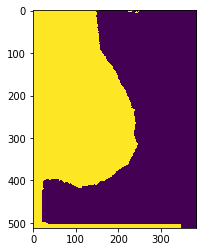

In [127]:
plt.imshow(bm)

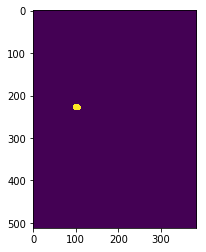

In [128]:
plt.imshow(m)

In [129]:
p_m = p*bm
p_m[p_m > p_m.mean() + p_m.std()] = 1
p_m[p_m < p_m.mean() + p_m.std()] = 0

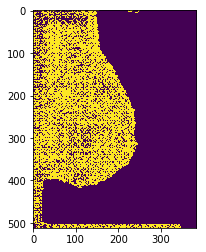

In [130]:
plt.imshow(p_m)

In [131]:
p_m_t = torch.Tensor(p_m)
print(nn.L1Loss()(torch.Tensor(p_m),torch.zeros(p_m_t.shape)))

tensor(0.3177)


In [63]:
p*bm

array([[0.46625924, 0.45731243, 0.41547447, ..., 0.        , 0.        ,
        0.        ],
       [0.5268079 , 0.47340256, 0.569443  , ..., 0.        , 0.        ,
        0.        ],
       [0.48511967, 0.26132625, 0.31252542, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.5489551 , 0.47492415, 0.57461685, ..., 0.        , 0.        ,
        0.3715244 ],
       [0.46561328, 0.4479155 , 0.49100143, ..., 0.        , 0.        ,
        0.        ],
       [0.5413707 , 0.3038033 , 0.420983  , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

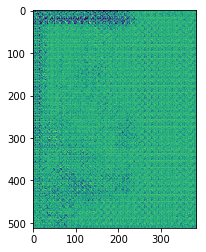

In [64]:
plt.imshow(p)